In [65]:
import pandas as pd
import numpy as np
import datetime as dt

In [66]:
data = pd.read_csv("query_result_2020-05-26T16 35 31.782649Z_last6month_creat_date.csv", parse_dates=\
["creation_time_profile", 'execution_time', 'first_note_date', 'ftd_time', 'last_trade_date', 'last_deposit_time', 'ltd_time'])

In [68]:
# excluding (...) for large number of columns
pd.set_option("display.max.columns", None) 

In [69]:
# filtering ftd only
data = data[data['ftd']==1]

In [70]:
# adding index column
data = data.reset_index()

In [71]:
# transforming our date columns to 'yyyy-mm-dd' format
data['ltd_time'] = [d.date() for d in data['ltd_time']]
data['ftd_time'] = [d.date() for d in data['ftd_time']]

In [72]:
# checking
data['ltd_time']

0       2020-03-06
1       2020-04-26
2       2020-03-06
3       2020-04-20
4       2020-03-23
           ...    
5921    2020-03-30
5922    2020-01-04
5923    2020-02-13
5924    2020-02-26
5925    2020-02-25
Name: ltd_time, Length: 5926, dtype: object

In [73]:
# grouping by client_id and last active month
data['LastMonth'] = pd.to_datetime(data['ltd_time']).dt.to_period('M')
grouping = data.groupby('profile_id')['LastMonth']

# adding column with cohort month
data['CohortMonth'] = pd.to_datetime(data['ftd_time']).dt.to_period('M')

In [74]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [75]:
# getting year and month
invoice_year, invoice_month, _ = get_date_int(data, 'LastMonth')
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

# calculating the difference between cohort month and last active month
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# creating cohort index
data['CohortIndex'] = years_diff * 12 + months_diff + 1

In [76]:
# filtering out one row with corrupted data
data['CohortIndex'] = data['CohortIndex'].sort_values().tail(5924)

In [77]:
# grouping and pivoting
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['profile_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                    columns='CohortIndex',
                                    values='profile_id')
print(cohort_counts)

CohortIndex     1.0    2.0   3.0   4.0   5.0   6.0  7.0
CohortMonth                                            
2019-11       456.0   44.0  34.0  18.0   5.0   2.0  3.0
2019-12       614.0   70.0  43.0  33.0  13.0  13.0  NaN
2020-01       739.0   69.0  43.0  15.0  13.0   NaN  NaN
2020-02       906.0   89.0  31.0  30.0   NaN   NaN  NaN
2020-03      1213.0  193.0  90.0   NaN   NaN   NaN  NaN
2020-04       900.0  139.0   NaN   NaN   NaN   NaN  NaN
2020-05       106.0    NaN   NaN   NaN   NaN   NaN  NaN


In [78]:
# storing the first column as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

In [79]:
cohort_sizes

CohortMonth
2019-11     456.0
2019-12     614.0
2020-01     739.0
2020-02     906.0
2020-03    1213.0
2020-04     900.0
2020-05     106.0
Freq: M, Name: 1.0, dtype: float64

In [80]:
# dividing all values in the cohort_counts table by cohort_sizes to get retention %%
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [81]:
# retention rates in %%
retention.round(3) * 100

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0
CohortMonth,,,,,,,
2019-11,100.0,9.6,7.5,3.9,1.1,0.4,0.7
2019-12,100.0,11.4,7.0,5.4,2.1,2.1,NaN
2020-01,100.0,9.3,5.8,2.0,1.8,NaN,NaN
2020-02,100.0,9.8,3.4,3.3,NaN,NaN,NaN
2020-03,100.0,15.9,7.4,NaN,NaN,NaN,NaN
2020-04,100.0,15.4,NaN,NaN,NaN,NaN,NaN
2020-05,100.0,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['deposit_usd'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',
    columns='CohortIndex',
    values='deposit_usd')

# avg monetary deposits
average_quantity.round(1)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0
CohortMonth,,,,,,,
2019-11,289.3,385.5,272.3,263.3,294.2,447.6,267.2
2019-12,282.2,269.8,263.2,270.6,687.2,266.6,NaN
2020-01,295.8,429.2,326.0,1014.4,290.6,NaN,NaN
2020-02,277.7,298.8,282.3,398.9,NaN,NaN,NaN
2020-03,284.0,319.7,384.1,NaN,NaN,NaN,NaN
2020-04,324.7,321.9,NaN,NaN,NaN,NaN,NaN
2020-05,266.8,NaN,NaN,NaN,NaN,NaN,NaN


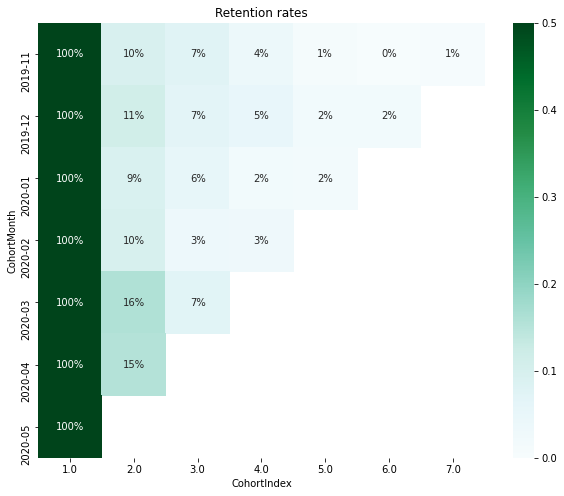

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
    annot = True,
    fmt = '.0%',
    vmin = 0.0,
    vmax = 0.5,
    cmap = 'BuGn')
plt.show()

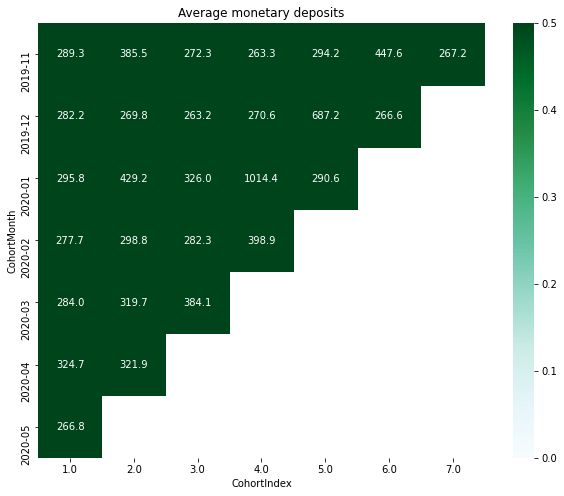

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title('Average monetary deposits')
sns.heatmap(data = average_quantity,
    annot = True,
    fmt = '.1f',
    vmin = 0.0,
    vmax = 0.5,
    cmap = 'BuGn')
plt.show()